# I. IMPORT & SET UP

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import urllib.parse
import os
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

pd.set_option('display.max_colwidth', None)

In [39]:
import plotly
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 14})

In [2]:
PROJECT_DIR = os.getcwd()
ID_DIR_NAME = 'job_id_dir'
INFO_DIR_NAME = 'job_info_dir'

# II. CLEANING

#### Load most recent DataFrame from csv file

In [3]:
JOB_INFO_PATH = os.path.join(PROJECT_DIR, INFO_DIR_NAME, sorted(os.listdir(os.path.join(PROJECT_DIR, INFO_DIR_NAME)))[-1])

job_df = pd.read_csv(JOB_INFO_PATH, index_col=0, sep='@')
job_df.head(5)

,Job ID,Job URL,Name,Company,Company Logo URL,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview
0,3520044004,https://www.linkedin.com/jobs/view/3520044004,"Data Scientist, Research",TikTok,https://media.licdn.com/dms/image/C510BAQGCdThXIss7UQ/company-logo_100_100/0/1539940587971?e=1687996800&v=beta&t=1AyKLKEh0SiRwHFVslSVLJ-5LaOWsCzFqZtQ9ZvHi1o,"San Jose, CA",Hybrid,2 weeks ago,198 applicants,Full-time,"10,001+ employees · Entertainment Providers"
1,3523743282,https://www.linkedin.com/jobs/view/3523743282,Global Data Scientist,Kimberly-Clark,https://media.licdn.com/dms/image/C560BAQFahtjOdf_ETQ/company-logo_100_100/0/1542208571146?e=1687996800&v=beta&t=y-aRHU6gnrNyr6nMPswJJHlWEoEOjZyHL-a1Qs5MPFY,United States,Remote,2 weeks ago,Over 200 applicants,Full-time · Mid-Senior level,"10,001+ employees · Manufacturing"
2,3520459813,https://www.linkedin.com/jobs/view/3520459813,Data Analytics Intern (Summer 2023),Industry Dive,https://media.licdn.com/dms/image/C4E0BAQEAkpLAgFUtpA/company-logo_100_100/0/1520994058492?e=1687996800&v=beta&t=wkHpT8VLjHRZryS_VDdpboOGmMkNRTNhMqVoDrCC2_M,"Washington, DC",Remote,NaN,NaN,$16/hr - $21/hr (from job description) · Internship · Internship,201-500 employees · Online Audio and Video Media
3,3525723554,https://www.linkedin.com/jobs/view/3525723554,Data Scientist Solution Specialist- IT Internship,Waters Corporation,https://media.licdn.com/dms/image/C560BAQHFDhBFVWfhzg/company-logo_100_100/0/1656651227123?e=1687996800&v=beta&t=YmLFUIyNIljy5hv0bST7P3wzrzdVBRln9qUpFAufG0c,"Milford, MA",On-site,1 week ago,Over 200 applicants,Internship · Internship,"5,001-10,000 employees · Biotechnology Research"
4,3527821880,https://www.linkedin.com/jobs/view/3527821880,Data Engineer,Chatham Financial,https://media.licdn.com/dms/image/C4D0BAQFPJJtAqKZSKA/company-logo_100_100/0/1566565993951?e=1687996800&v=beta&t=w4VlO0akxyqbbvH7Io6cMb3i8qShWG84zirwSGF-rDM,"Kennett Square, PA",On-site,2 weeks ago,104 applicants,Full-time · Entry level,"501-1,000 employees · Financial Services"


In [4]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 0 to 884
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Job ID            885 non-null    int64 
 1   Job URL           885 non-null    object
 2   Name              885 non-null    object
 3   Company           883 non-null    object
 4   Company Logo URL  885 non-null    object
 5   Location          885 non-null    object
 6   Workplace Type    754 non-null    object
 7   Time Posted       778 non-null    object
 8   Applicants Count  776 non-null    object
 9   Job Overview      885 non-null    object
 10  Company Overview  885 non-null    object
dtypes: int64(1), object(10)
memory usage: 83.0+ KB


In [5]:
job_df_2 = job_df.copy() # Make a copy

### Split Location
New columns:
- Location_City
- Location_State

In [6]:
job_df['Location'].str.split(', ').map(len).value_counts()

2    776
1    104
3      5
Name: Location, dtype: int64

#### Locations that have 3 values:

- City, States, Country

In [7]:
idx = job_df[job_df['Location'].str.split(', ').map(len)==3].index.to_list()
job_df[['Location_City', 'Location_State', 'Location_Country']] = job_df.iloc[idx]['Location'].str.split(', ', expand=True)
job_df.iloc[idx, 5:]

,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Location_Country
158,"Los Angeles, California, United States",Remote,NaN,NaN,"$130,000/yr - $180,000/yr (from job description) · Full-time · Mid-Senior level","501-1,000 employees · Staffing and Recruiting",Los Angeles,California,United States
460,"Fort Bragg, North Carolina, United States",On-site,2 weeks ago,76 applicants,Full-time · Entry level,51-200 employees · IT Services and IT Consulting,Fort Bragg,North Carolina,United States
477,"Fort Bragg, North Carolina, United States",NaN,2 weeks ago,1 applicant,Full-time · Entry level,11-50 employees · Defense and Space Manufacturing,Fort Bragg,North Carolina,United States
577,"La Jolla, California, United States",On-site,2 weeks ago,5 applicants,Contract · Entry level,"1,001-5,000 employees · Staffing and Recruiting",La Jolla,California,United States
691,"New York, New York, United States",NaN,1 week ago,45 applicants,"$105,000/yr - $116,000/yr (from job description) · Full-time · Mid-Senior level","10,001+ employees · Telecommunications",New York,New York,United States


#### Locations that have 2 values:
- City, State
- State, Country

In [8]:
pattern_1 = r'(.+), (United States)'
pattern_2 = r'(.+), ([A-Z]{2})'
mask = (job_df['Location'].str.split(', ').map(len)==2)

for idx, row in job_df[mask].iterrows():
    seq = row['Location']

    location_1 = re.search(pattern_1, seq)
    location_2 = re.search(pattern_2, seq)

    if location_1:
        job_df.at[idx, 'Location_State'] = location_1.group(1)
    elif location_2:
        job_df.at[idx, 'Location_City'] = location_2.group(1)
        job_df.at[idx, 'Location_State'] = location_2.group(2)
    else:
        'Unknown'

job_df.iloc[10:15, 5:]

,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Location_Country
10,"Washington, DC",NaN,2 weeks ago,Over 200 applicants,Contract · Entry level,201-500 employees · Information Technology &amp; Services,Washington,DC,NaN
11,"Tampa, FL",Hybrid,2 weeks ago,83 applicants,Full-time · Mid-Senior level,"10,001+ employees · IT Services and IT Consulting",Tampa,FL,NaN
12,United States,Remote,1 week ago,Over 200 applicants,"$72,800/yr - $109,200/yr (from job description) · Full-time · Entry level",201-500 employees · Education Management,NaN,NaN,NaN
13,"Maine, United States",Hybrid,2 weeks ago,38 applicants,Full-time · Mid-Senior level,"501-1,000 employees · Technology, Information and Internet",NaN,Maine,NaN
14,"McLean, VA",Hybrid,2 weeks ago,113 applicants,"$58,400/yr - $133,000/yr (from job description) · Full-time","10,001+ employees · IT Services and IT Consulting",McLean,VA,NaN


### Except Washington DC

#### Locations that have only 1 information

In [9]:
job_df[~(job_df['Location'].str.contains(r', '))]['Location'].value_counts()

United States                          69
New York City Metropolitan Area         9
San Francisco Bay Area                  6
Washington DC-Baltimore Area            3
Greater Boston                          3
Cincinnati Metropolitan Area            2
Greater Chicago Area                    2
Des Moines Metropolitan Area            2
Dallas-Fort Worth Metroplex             2
Atlanta Metropolitan Area               1
Greater Sacramento                      1
Greater Houston                         1
Greater Vancouver Metropolitan Area     1
Greater Seattle Area                    1
Los Angeles Metropolitan Area           1
Name: Location, dtype: int64

In [10]:
mask = ~(job_df['Location'].str.contains(r', ')) & (job_df['Location']!='United States')
job_df.loc[mask, 'Location_City'] = job_df[mask]['Location']
job_df[mask].iloc[:3,5:]

,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Location_Country
39,New York City Metropolitan Area,Hybrid,1 week ago,185 applicants,Contract,"10,001+ employees · Beverage Manufacturing",New York City Metropolitan Area,NaN,NaN
56,Washington DC-Baltimore Area,Hybrid,2 weeks ago,33 applicants,"$85,000/yr · Full-time",1-10 employees,Washington DC-Baltimore Area,NaN,NaN
117,Cincinnati Metropolitan Area,Hybrid,1 day ago,Over 200 applicants,Contract · Mid-Senior level,"501-1,000 employees · IT Services and IT Consulting",Cincinnati Metropolitan Area,NaN,NaN


### Match State Names with Abbreviation

In [11]:
# remove city col for jobs in Washington, DC
job_df.loc[job_df['Location_City']=='Washington', 'Location_City'] = None

In [12]:
states_dict = {
'Alabama':	            'AL',
'Kentucky':	            'KY',
'Ohio':	                'OH',
'Alaska':	            'AK',
'Louisiana':	        'LA',
'Oklahoma':	            'OK',
'Arizona':	            'AZ',
'Maine':	            'ME',
'Oregon':	            'OR',
'Arkansas':	            'AR',
'Maryland':	            'MD',
'Pennsylvania':	        'PA',
'American Samoa':	    'AS',
'Massachusetts':	    'MA',
'Puerto Rico':	        'PR',
'California':	        'CA',
'Michigan':	            'MI',
'Rhode Island':	        'RI',
'Colorado':	            'CO',
'Minnesota':	        'MN',
'South Carolina':	    'SC',
'Connecticut':	        'CT',
'Mississippi':	        'MS',
'South Dakota':	        'SD',
'Delaware':	            'DE',
'Missouri':	            'MO',
'Tennessee':	        'TN',
'District of Columbia':	'DC',	
'Montana':	            'MT',
'Texas':	            'TX',
'Florida':	            'FL',
'Nebraska':	            'NE',
'Trust Territories':	'TT',
'Georgia':	            'GA',
'Nevada':	            'NV',
'Utah':	                'UT',
'Guam':	                'GU',
'New Hampshire':	    'NH',
'Vermont':	            'VT',
'Hawaii':	            'HI',
'New Jersey':	        'NJ',
'Virginia':	            'VA',
'Idaho':	            'ID',
'New Mexico':	        'NM',
'Virgin Islands':	    'VI',
'Illinois':	            'IL',
'New York':	            'NY',
'Washington':	        'WA',
'Indiana':	            'IN',
'North Carolina':	    'NC',
'West Virginia':	    'WV',
'Iowa':	                'IA',
'North Dakota':	        'ND',
'Wisconsin':	        'WI',
'Kansas':	            'KS',
'Northern Mariana Islands':	'MP',	
'Wyoming':	            'WY'
}
states_dict = dict(sorted(states_dict.items()))
states_dict = dict((v, k) for k, v in states_dict.items())
states_dict

{'AL': 'Alabama',
 'AK': 'Alaska',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'MP': 'Northern Mariana Islands',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'TT': 'Trust Territories',
 'UT': 

In [13]:
job_df['Location_State'] = job_df['Location_State'].apply(lambda x: states_dict[x] if x in states_dict else x)
job_df['Location_State'].unique()

array(['California', nan, 'District of Columbia', 'Massachusetts',
       'Pennsylvania', 'New Jersey', 'Illinois', 'Virginia', 'Florida',
       'Maine', 'Kansas', 'Texas', 'Colorado', 'Nevada', 'Arkansas',
       'Georgia', 'Maryland', 'New York', 'Delaware', 'Washington',
       'North Carolina', 'Connecticut', 'Rhode Island', 'Missouri',
       'South Carolina', 'Indiana', 'Iowa', 'Ohio', 'Hawaii',
       'New Hampshire', 'Alabama', 'Wisconsin', 'Oklahoma', 'Tennessee',
       'Michigan', 'Kentucky', 'Oregon', 'Idaho', 'Minnesota', 'Vermont',
       'Nebraska', 'Arizona', 'South Dakota', 'Louisiana', 'Utah',
       'Mississippi', 'New Mexico', 'Montana'], dtype=object)

In [14]:
job_df = job_df.drop(columns=['Location_Country'])

#### Fill 'Remote' location for Remote jobs

In [15]:
job_df.loc[(job_df['Workplace Type']=='Remote'), 'Location_City'] = 'Remote'
job_df.loc[(job_df['Workplace Type']=='Remote'), 'Location_State'] = 'Remote'

In [16]:
job_df.iloc[10:15,5:] # Recheck

,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State
10,"Washington, DC",NaN,2 weeks ago,Over 200 applicants,Contract · Entry level,201-500 employees · Information Technology &amp; Services,None,District of Columbia
11,"Tampa, FL",Hybrid,2 weeks ago,83 applicants,Full-time · Mid-Senior level,"10,001+ employees · IT Services and IT Consulting",Tampa,Florida
12,United States,Remote,1 week ago,Over 200 applicants,"$72,800/yr - $109,200/yr (from job description) · Full-time · Entry level",201-500 employees · Education Management,Remote,Remote
13,"Maine, United States",Hybrid,2 weeks ago,38 applicants,Full-time · Mid-Senior level,"501-1,000 employees · Technology, Information and Internet",NaN,Maine
14,"McLean, VA",Hybrid,2 weeks ago,113 applicants,"$58,400/yr - $133,000/yr (from job description) · Full-time","10,001+ employees · IT Services and IT Consulting",McLean,Virginia


### Split Company Overview
New columns:
- Company Size
- Industry

In [17]:
job_df['Company Overview'].str.split(' · ').map(len).value_counts()

2    844
1     41
Name: Company Overview, dtype: int64

In [18]:
list(set(job_df['Company Overview'].str.split(' · ').values.sum()))

['Medical Equipment Manufacturing',
 'Broadcast Media Production and Distribution',
 'Research',
 'Financial Services',
 'Law Enforcement',
 '1-10 employees',
 'Professional Services',
 'IT Services and IT Consulting',
 'Book and Periodical Publishing',
 'Aviation and Aerospace Component Manufacturing',
 'Consumer Services',
 '501-1,000 employees',
 'Semiconductors',
 'Retail',
 '5,001-10,000 employees',
 'Manufacturing',
 'Wellness and Fitness Services',
 'Oil and Gas',
 'Machinery Manufacturing',
 'See how you compare to 92 applicants.<span class="white-space-pre"> </span><a class="app-aware-link " target="_self" href="https://www.linkedin.com/premium/products/?family=JSS&amp;upsellOrderOrigin=premium_job_details_summary_card&amp;utype=job" data-test-app-aware-link="">Try Premium for free</a>',
 '51-200 employees',
 'Software Development',
 'Retail Apparel and Fashion',
 'Renewable Energy Semiconductor Manufacturing',
 'Medical Practices',
 'Truck Transportation',
 'Telecommunication

#### Remove invalid Company Overview values

In [19]:
job_df.loc[~job_df['Company Overview'].str.contains('employees')]

,Job ID,Job URL,Name,Company,Company Logo URL,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State
534,3525735059,https://www.linkedin.com/jobs/view/3525735059,Data Engineer,NaN,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7","Dallas, TX",Hybrid,1 week ago,92 applicants,Full-time · Mid-Senior level,"See how you compare to 92 applicants.<span class=""white-space-pre""> </span><a class=""app-aware-link "" target=""_self"" href=""https://www.linkedin.com/premium/products/?family=JSS&amp;upsellOrderOrigin=premium_job_details_summary_card&amp;utype=job"" data-test-app-aware-link="""">Try Premium for free</a>",Dallas,Texas
603,3525016432,https://www.linkedin.com/jobs/view/3525016432,Project Manager,NaN,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7","Stuart, FL",Hybrid,2 weeks ago,44 applicants,Full-time,Greg M. is hiring for this job,Stuart,Florida


In [20]:
job_df.loc[~job_df['Company Overview'].str.contains('employees'), 'Company Overview'] = 'Unknown' # replace invalid Company Overview with Unknown
job_df[job_df['Company Overview'] == 'Unknown'] # recheck

,Job ID,Job URL,Name,Company,Company Logo URL,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State
534,3525735059,https://www.linkedin.com/jobs/view/3525735059,Data Engineer,NaN,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7","Dallas, TX",Hybrid,1 week ago,92 applicants,Full-time · Mid-Senior level,Unknown,Dallas,Texas
603,3525016432,https://www.linkedin.com/jobs/view/3525016432,Project Manager,NaN,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7","Stuart, FL",Hybrid,2 weeks ago,44 applicants,Full-time,Unknown,Stuart,Florida


#### Split method 1: regex

In [21]:
# seq = '1-10 employees'
# seq = '5,001-10,000 employees'
# seq = '10,001+ employees · Entertainment Providers'
# seq = '201-500 employees · Online Audio and Video Media'
# pattern = r"(\d+,?\d*\+?[\-?\d+,?\d+]* employees)( · )?(.+)*"
# re.search(pattern, seq)

In [22]:
pattern = r"(\d+,?\d*\+?[\-?\d+,?\d+]* employees)( · )?(.+)*"

for idx, row in job_df.iterrows():
    seq = row['Company Overview']
    company_overview = re.search(pattern, seq)
    job_df.at[idx, 'Company Size'] = company_overview.group(1) if company_overview is not None else 'Unknown'
    job_df.at[idx, 'Industry'] = company_overview.group(3) if company_overview is not None else 'Unknown'

job_df.iloc[:10, 5:]

,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Company Size,Industry
0,"San Jose, CA",Hybrid,2 weeks ago,198 applicants,Full-time,"10,001+ employees · Entertainment Providers",San Jose,California,"10,001+ employees",Entertainment Providers
1,United States,Remote,2 weeks ago,Over 200 applicants,Full-time · Mid-Senior level,"10,001+ employees · Manufacturing",Remote,Remote,"10,001+ employees",Manufacturing
2,"Washington, DC",Remote,NaN,NaN,$16/hr - $21/hr (from job description) · Internship · Internship,201-500 employees · Online Audio and Video Media,Remote,Remote,201-500 employees,Online Audio and Video Media
3,"Milford, MA",On-site,1 week ago,Over 200 applicants,Internship · Internship,"5,001-10,000 employees · Biotechnology Research",Milford,Massachusetts,"5,001-10,000 employees",Biotechnology Research
4,"Kennett Square, PA",On-site,2 weeks ago,104 applicants,Full-time · Entry level,"501-1,000 employees · Financial Services",Kennett Square,Pennsylvania,"501-1,000 employees",Financial Services
5,"Basking Ridge, NJ",NaN,2 days ago,25 applicants,Full-time,"1,001-5,000 employees · Pharmaceutical Manufacturing",Basking Ridge,New Jersey,"1,001-5,000 employees",Pharmaceutical Manufacturing
6,"Chicago, IL",Hybrid,2 weeks ago,Over 200 applicants,"$85,000/yr - $130,000/yr · Full-time · Mid-Senior level",11-50 employees · Staffing and Recruiting,Chicago,Illinois,11-50 employees,Staffing and Recruiting
7,"Washington, DC",Hybrid,2 weeks ago,Over 200 applicants,Full-time · Associate,51-200 employees · Defense and Space Manufacturing,None,District of Columbia,51-200 employees,Defense and Space Manufacturing
8,"McLean, VA",Hybrid,1 week ago,67 applicants,Full-time · Mid-Senior level,"1,001-5,000 employees · Staffing and Recruiting",McLean,Virginia,"1,001-5,000 employees",Staffing and Recruiting
9,"Indianola, PA",Hybrid,2 weeks ago,43 applicants,"$120,000/yr · Contract · Mid-Senior level","10,001+ employees · Chemical Manufacturing",Indianola,Pennsylvania,"10,001+ employees",Chemical Manufacturing


#### Split method 2: .split()

In [23]:
# mask = job_df[job_df['Company Overview'].str.contains('employees')]
# job_df[['Company Size', 'Industry']] = job_df['Company Overview'].str.split(' · ', expand=True)
# job_df.head()

*Note: This method only works when Company size is available in Company Overview*

### Split Job Overview

- Salary
- Workplace Type
- Level of Expertise

#### Create Salary Column

In [24]:
# salary_pattern = r"\$(\d)+.*\/(yr|hr)"
# seq = '$50,000/yr - $75,000/yr (from job description) · Full-time · Associate'
# seq = '$16.74/hr - $21.75/hr'
# seq = '$20/hr - $23/hr'
# seq = '$40/hr - $45/hr'
# result = re.search(salary_pattern, seq)
# result.group()

In [25]:
salary_pattern = r"\$(\d)+.*\/(yr|hr)"

for idx, row in job_df.iterrows():
    job_overview = row['Job Overview']
    try:
        salary = re.search(salary_pattern, job_overview)
        job_df.at[idx, 'Salary'] = salary.group() if salary is not None else 'Unknown'
    except NoSuchElementException:
        pass

job_df.head(5)

,Job ID,Job URL,Name,Company,Company Logo URL,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Company Size,Industry,Salary
0,3520044004,https://www.linkedin.com/jobs/view/3520044004,"Data Scientist, Research",TikTok,https://media.licdn.com/dms/image/C510BAQGCdThXIss7UQ/company-logo_100_100/0/1539940587971?e=1687996800&v=beta&t=1AyKLKEh0SiRwHFVslSVLJ-5LaOWsCzFqZtQ9ZvHi1o,"San Jose, CA",Hybrid,2 weeks ago,198 applicants,Full-time,"10,001+ employees · Entertainment Providers",San Jose,California,"10,001+ employees",Entertainment Providers,Unknown
1,3523743282,https://www.linkedin.com/jobs/view/3523743282,Global Data Scientist,Kimberly-Clark,https://media.licdn.com/dms/image/C560BAQFahtjOdf_ETQ/company-logo_100_100/0/1542208571146?e=1687996800&v=beta&t=y-aRHU6gnrNyr6nMPswJJHlWEoEOjZyHL-a1Qs5MPFY,United States,Remote,2 weeks ago,Over 200 applicants,Full-time · Mid-Senior level,"10,001+ employees · Manufacturing",Remote,Remote,"10,001+ employees",Manufacturing,Unknown
2,3520459813,https://www.linkedin.com/jobs/view/3520459813,Data Analytics Intern (Summer 2023),Industry Dive,https://media.licdn.com/dms/image/C4E0BAQEAkpLAgFUtpA/company-logo_100_100/0/1520994058492?e=1687996800&v=beta&t=wkHpT8VLjHRZryS_VDdpboOGmMkNRTNhMqVoDrCC2_M,"Washington, DC",Remote,NaN,NaN,$16/hr - $21/hr (from job description) · Internship · Internship,201-500 employees · Online Audio and Video Media,Remote,Remote,201-500 employees,Online Audio and Video Media,$16/hr - $21/hr
3,3525723554,https://www.linkedin.com/jobs/view/3525723554,Data Scientist Solution Specialist- IT Internship,Waters Corporation,https://media.licdn.com/dms/image/C560BAQHFDhBFVWfhzg/company-logo_100_100/0/1656651227123?e=1687996800&v=beta&t=YmLFUIyNIljy5hv0bST7P3wzrzdVBRln9qUpFAufG0c,"Milford, MA",On-site,1 week ago,Over 200 applicants,Internship · Internship,"5,001-10,000 employees · Biotechnology Research",Milford,Massachusetts,"5,001-10,000 employees",Biotechnology Research,Unknown
4,3527821880,https://www.linkedin.com/jobs/view/3527821880,Data Engineer,Chatham Financial,https://media.licdn.com/dms/image/C4D0BAQFPJJtAqKZSKA/company-logo_100_100/0/1566565993951?e=1687996800&v=beta&t=w4VlO0akxyqbbvH7Io6cMb3i8qShWG84zirwSGF-rDM,"Kennett Square, PA",On-site,2 weeks ago,104 applicants,Full-time · Entry level,"501-1,000 employees · Financial Services",Kennett Square,Pennsylvania,"501-1,000 employees",Financial Services,Unknown


#### Create Workplace Type & Level of Expertise columns

In [26]:
tmp = job_df.copy()
tmp = tmp['Job Overview'].str.replace(' (from job description)', '', regex=False)
tmp = tmp.str.replace(r'\$(\d)+.*\/(yr|hr)', '', regex=True).str.strip(' · ')
list(set(tmp.str.split(' · ').values.sum()))

['Full-time',
 '$6,597/month - $7,431/month',
 'Temporary',
 '$5,380/month - $7,372/month',
 'Mid-Senior level',
 'Executive',
 'Associate',
 'Entry level',
 'Director',
 'Internship',
 'Contract',
 '$5,250/month - $5,583/month',
 'Part-time']

In [27]:
contract_type_list = ['Temporary', 'Part-time', 'Full-time', 'Internship', 'Contract']
contract_type_pattern = '|'.join(contract_type_list)

for idx, row in job_df.iterrows():
    job_overview = row['Job Overview']
    try:
        contract_type = re.search(contract_type_pattern, job_overview)
        job_df.at[idx, 'Contract Type'] = contract_type.group() if contract_type is not None else 'Unknown'
    except NoSuchElementException:
        pass
job_df.head(5)

,Job ID,Job URL,Name,Company,Company Logo URL,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Company Size,Industry,Salary,Contract Type
0,3520044004,https://www.linkedin.com/jobs/view/3520044004,"Data Scientist, Research",TikTok,https://media.licdn.com/dms/image/C510BAQGCdThXIss7UQ/company-logo_100_100/0/1539940587971?e=1687996800&v=beta&t=1AyKLKEh0SiRwHFVslSVLJ-5LaOWsCzFqZtQ9ZvHi1o,"San Jose, CA",Hybrid,2 weeks ago,198 applicants,Full-time,"10,001+ employees · Entertainment Providers",San Jose,California,"10,001+ employees",Entertainment Providers,Unknown,Full-time
1,3523743282,https://www.linkedin.com/jobs/view/3523743282,Global Data Scientist,Kimberly-Clark,https://media.licdn.com/dms/image/C560BAQFahtjOdf_ETQ/company-logo_100_100/0/1542208571146?e=1687996800&v=beta&t=y-aRHU6gnrNyr6nMPswJJHlWEoEOjZyHL-a1Qs5MPFY,United States,Remote,2 weeks ago,Over 200 applicants,Full-time · Mid-Senior level,"10,001+ employees · Manufacturing",Remote,Remote,"10,001+ employees",Manufacturing,Unknown,Full-time
2,3520459813,https://www.linkedin.com/jobs/view/3520459813,Data Analytics Intern (Summer 2023),Industry Dive,https://media.licdn.com/dms/image/C4E0BAQEAkpLAgFUtpA/company-logo_100_100/0/1520994058492?e=1687996800&v=beta&t=wkHpT8VLjHRZryS_VDdpboOGmMkNRTNhMqVoDrCC2_M,"Washington, DC",Remote,NaN,NaN,$16/hr - $21/hr (from job description) · Internship · Internship,201-500 employees · Online Audio and Video Media,Remote,Remote,201-500 employees,Online Audio and Video Media,$16/hr - $21/hr,Internship
3,3525723554,https://www.linkedin.com/jobs/view/3525723554,Data Scientist Solution Specialist- IT Internship,Waters Corporation,https://media.licdn.com/dms/image/C560BAQHFDhBFVWfhzg/company-logo_100_100/0/1656651227123?e=1687996800&v=beta&t=YmLFUIyNIljy5hv0bST7P3wzrzdVBRln9qUpFAufG0c,"Milford, MA",On-site,1 week ago,Over 200 applicants,Internship · Internship,"5,001-10,000 employees · Biotechnology Research",Milford,Massachusetts,"5,001-10,000 employees",Biotechnology Research,Unknown,Internship
4,3527821880,https://www.linkedin.com/jobs/view/3527821880,Data Engineer,Chatham Financial,https://media.licdn.com/dms/image/C4D0BAQFPJJtAqKZSKA/company-logo_100_100/0/1566565993951?e=1687996800&v=beta&t=w4VlO0akxyqbbvH7Io6cMb3i8qShWG84zirwSGF-rDM,"Kennett Square, PA",On-site,2 weeks ago,104 applicants,Full-time · Entry level,"501-1,000 employees · Financial Services",Kennett Square,Pennsylvania,"501-1,000 employees",Financial Services,Unknown,Full-time


In [28]:
exp_levels_list = ['Entry level', 'Junior', 'Mid-Senior level', 'Associate', 'Executive', 'Director']
exp_levels_pattern = '|'.join(exp_levels_list)

for idx, row in job_df.iterrows():
    job_overview = row['Job Overview']
    try:
        exp_level = re.search(exp_levels_pattern, job_overview)
        job_df.at[idx, 'Level of Expertise'] = exp_level.group() if exp_level is not None else 'Unknown'
    except NoSuchElementException:
        pass
job_df.head(5)

,Job ID,Job URL,Name,Company,Company Logo URL,Location,Workplace Type,Time Posted,Applicants Count,Job Overview,Company Overview,Location_City,Location_State,Company Size,Industry,Salary,Contract Type,Level of Expertise
0,3520044004,https://www.linkedin.com/jobs/view/3520044004,"Data Scientist, Research",TikTok,https://media.licdn.com/dms/image/C510BAQGCdThXIss7UQ/company-logo_100_100/0/1539940587971?e=1687996800&v=beta&t=1AyKLKEh0SiRwHFVslSVLJ-5LaOWsCzFqZtQ9ZvHi1o,"San Jose, CA",Hybrid,2 weeks ago,198 applicants,Full-time,"10,001+ employees · Entertainment Providers",San Jose,California,"10,001+ employees",Entertainment Providers,Unknown,Full-time,Unknown
1,3523743282,https://www.linkedin.com/jobs/view/3523743282,Global Data Scientist,Kimberly-Clark,https://media.licdn.com/dms/image/C560BAQFahtjOdf_ETQ/company-logo_100_100/0/1542208571146?e=1687996800&v=beta&t=y-aRHU6gnrNyr6nMPswJJHlWEoEOjZyHL-a1Qs5MPFY,United States,Remote,2 weeks ago,Over 200 applicants,Full-time · Mid-Senior level,"10,001+ employees · Manufacturing",Remote,Remote,"10,001+ employees",Manufacturing,Unknown,Full-time,Mid-Senior level
2,3520459813,https://www.linkedin.com/jobs/view/3520459813,Data Analytics Intern (Summer 2023),Industry Dive,https://media.licdn.com/dms/image/C4E0BAQEAkpLAgFUtpA/company-logo_100_100/0/1520994058492?e=1687996800&v=beta&t=wkHpT8VLjHRZryS_VDdpboOGmMkNRTNhMqVoDrCC2_M,"Washington, DC",Remote,NaN,NaN,$16/hr - $21/hr (from job description) · Internship · Internship,201-500 employees · Online Audio and Video Media,Remote,Remote,201-500 employees,Online Audio and Video Media,$16/hr - $21/hr,Internship,Unknown
3,3525723554,https://www.linkedin.com/jobs/view/3525723554,Data Scientist Solution Specialist- IT Internship,Waters Corporation,https://media.licdn.com/dms/image/C560BAQHFDhBFVWfhzg/company-logo_100_100/0/1656651227123?e=1687996800&v=beta&t=YmLFUIyNIljy5hv0bST7P3wzrzdVBRln9qUpFAufG0c,"Milford, MA",On-site,1 week ago,Over 200 applicants,Internship · Internship,"5,001-10,000 employees · Biotechnology Research",Milford,Massachusetts,"5,001-10,000 employees",Biotechnology Research,Unknown,Internship,Unknown
4,3527821880,https://www.linkedin.com/jobs/view/3527821880,Data Engineer,Chatham Financial,https://media.licdn.com/dms/image/C4D0BAQFPJJtAqKZSKA/company-logo_100_100/0/1566565993951?e=1687996800&v=beta&t=w4VlO0akxyqbbvH7Io6cMb3i8qShWG84zirwSGF-rDM,"Kennett Square, PA",On-site,2 weeks ago,104 applicants,Full-time · Entry level,"501-1,000 employees · Financial Services",Kennett Square,Pennsylvania,"501-1,000 employees",Financial Services,Unknown,Full-time,Entry level


### Replace all None and emptry strings with Unknown

In [29]:
job_df = job_df.replace('', np.nan).fillna('Unknown')

# III. EDA

In [470]:
cols = ['Job URL', 'Name', 'Company', 'Location', 'Location_City', 'Location_State',
       'Workplace Type', 'Time Posted', 'Applicants Count',
        'Salary', 'Contract Type', 'Level of Expertise',
       'Company Size', 'Industry']
df = job_df[cols]

In [471]:
df.head(10)

,Job URL,Name,Company,Location,Location_City,Location_State,Workplace Type,Time Posted,Applicants Count,Salary,Contract Type,Level of Expertise,Company Size,Industry
0,https://www.linkedin.com/jobs/view/3520044004,"Data Scientist, Research",TikTok,"San Jose, CA",San Jose,California,Hybrid,2 weeks ago,198 applicants,Unknown,Full-time,Unknown,"10,001+ employees",Entertainment Providers
1,https://www.linkedin.com/jobs/view/3523743282,Global Data Scientist,Kimberly-Clark,United States,Remote,Remote,Remote,2 weeks ago,Over 200 applicants,Unknown,Full-time,Mid-Senior level,"10,001+ employees",Manufacturing
2,https://www.linkedin.com/jobs/view/3520459813,Data Analytics Intern (Summer 2023),Industry Dive,"Washington, DC",Remote,Remote,Remote,Unknown,Unknown,$16/hr - $21/hr,Internship,Unknown,201-500 employees,Online Audio and Video Media
3,https://www.linkedin.com/jobs/view/3525723554,Data Scientist Solution Specialist- IT Internship,Waters Corporation,"Milford, MA",Milford,Massachusetts,On-site,1 week ago,Over 200 applicants,Unknown,Internship,Unknown,"5,001-10,000 employees",Biotechnology Research
4,https://www.linkedin.com/jobs/view/3527821880,Data Engineer,Chatham Financial,"Kennett Square, PA",Kennett Square,Pennsylvania,On-site,2 weeks ago,104 applicants,Unknown,Full-time,Entry level,"501-1,000 employees",Financial Services
5,https://www.linkedin.com/jobs/view/3545964641,"Programmer, Data Analysis, Epidemiology Analytics","Daiichi Sankyo, Inc.","Basking Ridge, NJ",Basking Ridge,New Jersey,Unknown,2 days ago,25 applicants,Unknown,Full-time,Unknown,"1,001-5,000 employees",Pharmaceutical Manufacturing
6,https://www.linkedin.com/jobs/view/3520729278,Investment Data Analyst,Westbourne Partners,"Chicago, IL",Chicago,Illinois,Hybrid,2 weeks ago,Over 200 applicants,"$85,000/yr - $130,000/yr",Full-time,Mid-Senior level,11-50 employees,Staffing and Recruiting
7,https://www.linkedin.com/jobs/view/3516637194,"Data Scientist, DC",Rhombus Power Inc.,"Washington, DC",Unknown,District of Columbia,Hybrid,2 weeks ago,Over 200 applicants,Unknown,Full-time,Associate,51-200 employees,Defense and Space Manufacturing
8,https://www.linkedin.com/jobs/view/3527065467,Data Operations Engineer / Business Operations Analyst,US Tech Solutions,"McLean, VA",McLean,Virginia,Hybrid,1 week ago,67 applicants,Unknown,Full-time,Mid-Senior level,"1,001-5,000 employees",Staffing and Recruiting
9,https://www.linkedin.com/jobs/view/3522212905,Medical Software Quality Engineer - $120k/yr,Bayer,"Indianola, PA",Indianola,Pennsylvania,Hybrid,2 weeks ago,43 applicants,"$120,000/yr",Contract,Mid-Senior level,"10,001+ employees",Chemical Manufacturing


In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 0 to 884
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job URL             885 non-null    object
 1   Name                885 non-null    object
 2   Company             885 non-null    object
 3   Location            885 non-null    object
 4   Location_City       885 non-null    object
 5   Location_State      885 non-null    object
 6   Workplace Type      885 non-null    object
 7   Time Posted         885 non-null    object
 8   Applicants Count    885 non-null    object
 9   Salary              885 non-null    object
 10  Contract Type       885 non-null    object
 11  Level of Expertise  885 non-null    object
 12  Company Size        885 non-null    object
 13  Industry            885 non-null    object
dtypes: object(14)
memory usage: 136.0+ KB


### 1. FILTER OUT DATA ANALYST JOBS

In [482]:
# r"data|bi|analyst|analytics|machine learning|ml|ai|intelligence"
mask_da = (df.Name.str.contains(r"data analyst|analyst|analytics", case=False, regex=True)) & ~(df.Name.str.contains(r"business analyst|business analytics", case=False, regex=True))
da_df = df[mask_da]
display(da_df.head())
print(f'Found {da_df.shape[0]} jobs relavant to data analyst')

,Job URL,Name,Company,Location,Location_City,Location_State,Workplace Type,Time Posted,Applicants Count,Salary,Contract Type,Level of Expertise,Company Size,Industry
2,https://www.linkedin.com/jobs/view/3520459813,Data Analytics Intern (Summer 2023),Industry Dive,"Washington, DC",Remote,Remote,Remote,Unknown,Unknown,$16/hr - $21/hr,Internship,Unknown,201-500 employees,Online Audio and Video Media
5,https://www.linkedin.com/jobs/view/3545964641,"Programmer, Data Analysis, Epidemiology Analytics","Daiichi Sankyo, Inc.","Basking Ridge, NJ",Basking Ridge,New Jersey,Unknown,2 days ago,25 applicants,Unknown,Full-time,Unknown,"1,001-5,000 employees",Pharmaceutical Manufacturing
6,https://www.linkedin.com/jobs/view/3520729278,Investment Data Analyst,Westbourne Partners,"Chicago, IL",Chicago,Illinois,Hybrid,2 weeks ago,Over 200 applicants,"$85,000/yr - $130,000/yr",Full-time,Mid-Senior level,11-50 employees,Staffing and Recruiting
8,https://www.linkedin.com/jobs/view/3527065467,Data Operations Engineer / Business Operations Analyst,US Tech Solutions,"McLean, VA",McLean,Virginia,Hybrid,1 week ago,67 applicants,Unknown,Full-time,Mid-Senior level,"1,001-5,000 employees",Staffing and Recruiting
12,https://www.linkedin.com/jobs/view/3532901532,Analyst,TNTP,United States,Remote,Remote,Remote,1 week ago,Over 200 applicants,"$72,800/yr - $109,200/yr",Full-time,Entry level,201-500 employees,Education Management


Found 231 jobs relavant to data analyst


#### HELP FUNCTIONS

In [474]:
def create_df(data, col, horizontal=True):
    df = data[col].value_counts().reset_index(name='Number of companies').rename(columns={'index': col})
    total = df['Number of companies'].sum()
    df['Percentage'] = np.round(df['Number of companies'] / total * 100,2)
    return df

In [475]:
def plot_pie(data, title, nrows=-1):
    sns.set(style="whitegrid", font_scale=1.5)
    max_rows = data.shape[0]
    nrows = min(max_rows, nrows) if nrows>0 else max_rows
    data = data.head(nrows)
    labels = data.iloc[:, 0].values
    values = data.iloc[:, 1].values
    #colors = ['tomato', 'lightcoral', 'gold', 'lightskyblue', 'yellowgreen']
    colors = sns.color_palette('rocket_r')
    explode = [0.05,] * nrows
    
    patches, texts, autotexts = plt.pie(values, labels=labels, colors=colors, explode=explode,
            counterclock=False, startangle=90,
            autopct = lambda x: f'{x:.1f}%\n({x * np.sum(values) / 100:.0f})', 
        #     textprops={'color': 'w'}, 
            wedgeprops=dict(width=0.5), # create a hole inside plot
            pctdistance=0.75 # move the percentage inside the arcs
            )
    # [text.set_color('red') for text in texts] # change color of text 
    [autotext.set_color('white') for autotext in autotexts]
    plt.suptitle(title, size=20)

    # # Customize text labels
    # for text in texts:
    #     text.set_horizontalalignment('center')
    # # Customize percent labels
    # for autotext in autotexts:
    #     autotext.set_horizontalalignment('center')
    #     autotext.set_fontstyle('italic')

    # plt.legend(
    #           title="Location",
    #           loc="center left",
    #           bbox_to_anchor=(.95, 0, 0.5, 1))

In [476]:
def plot_hbar(data, title, xlabel, plt_text_ratio=.08, nrows=-1):

    def colors_from_values(values: pd.Series, palette_name:str, ascending=True):
        '''
        Returns a seaborn palette reordered by value
        Parameters:
        values: pd.Series
        palette_name:str, Seaborn valid palette name
        ascending: bool, optional color sort order
        '''
        # convert to indices
        values = values.reset_index()
        indices = values.index
        # use the indices to get the colors
        palette = sns.color_palette(palette_name, len(values))
        return np.array(palette).take(indices, axis=0)

    max_rows = data.shape[0]
    nrows = min(max_rows, nrows) if nrows>0 else max_rows
    data = data.head(nrows)
    x = data.iloc[:, 1].values
    y = data.iloc[:, 0].values
    text = data.iloc[:, 2].values
    pallete = colors_from_values(data.iloc[:,:1], 'rocket_r')
    sns.set(style="whitegrid", font_scale=1.5)

    sns.barplot(x=x, y=y, palette=pallete)
    # show pct text on each bar
    fontsize = 14
    textcolor = 'white'
    for i, (val, pct) in enumerate(zip(data.iloc[:,1], data.iloc[:, 2])):
        plt.text(val - plt_text_ratio*max(data.iloc[:,1]), i, f'{pct:.2f}% ({val})', ha='center', va='center', color = textcolor, fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.suptitle(title, size=20)
    plt.show()

### IV. VISUALIZATIONS

### 1. LOCATIONS

#### 1.1 TOP STATES

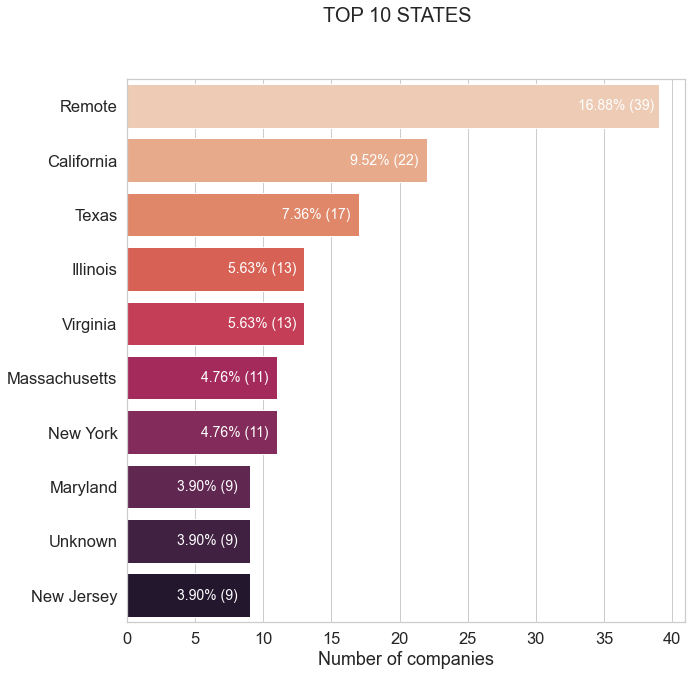

In [490]:
plt.figure(figsize=(10,10))
plot_df = create_df(da_df, 'Location_State')
nrows = 10 # to plot all rows: set to 0 or -1
title = 'TOP 10 STATES'
xlabel = 'Number of companies'
plot_hbar(plot_df, title=title, xlabel= xlabel, nrows=nrows)
plt.show()

#### 1.2 LOCATIONS NEAR ME

Found 13 jobs in Illinois state.


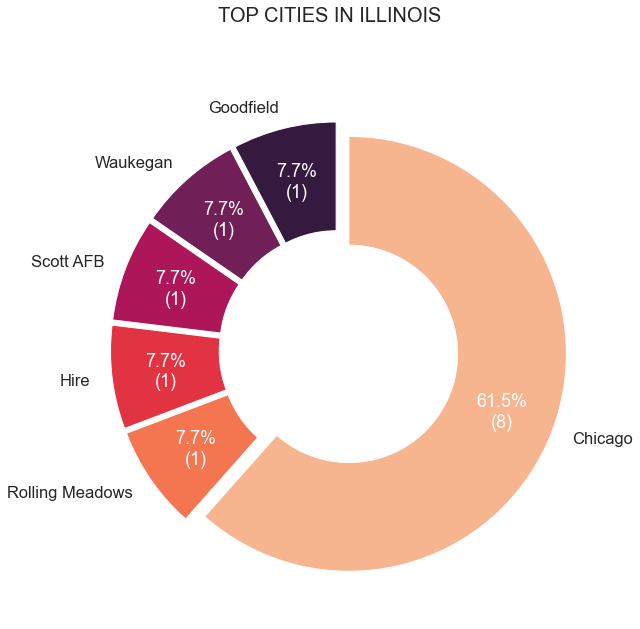

In [484]:
loc = 'Illinois'
df_2 = da_df[da_df["Location_State"]==loc]
print(f'Found {df_2.shape[0]} jobs in {loc} state.')

plt.figure(figsize=(10,10))
col = 'Location_City'
plot_df = create_df(df_2, 'Location_City')
nrows = -1 # to plot all rows: set to 0 or -1
title = f'TOP CITIES IN {loc.upper()}'
plot_pie(plot_df, title=title, nrows=nrows)
plt.show()

#### 1.3 REMOTE LOCATION

In [485]:
loc = 'Remote'
df_3 = da_df[da_df["Location_State"]==loc]
print(f'Found {df_3.shape[0]} jobs in {loc} location.')

Found 39 jobs in Remote location.


### 2. INDUSTRIES

#### 2.1 TOP INDUSTRIES

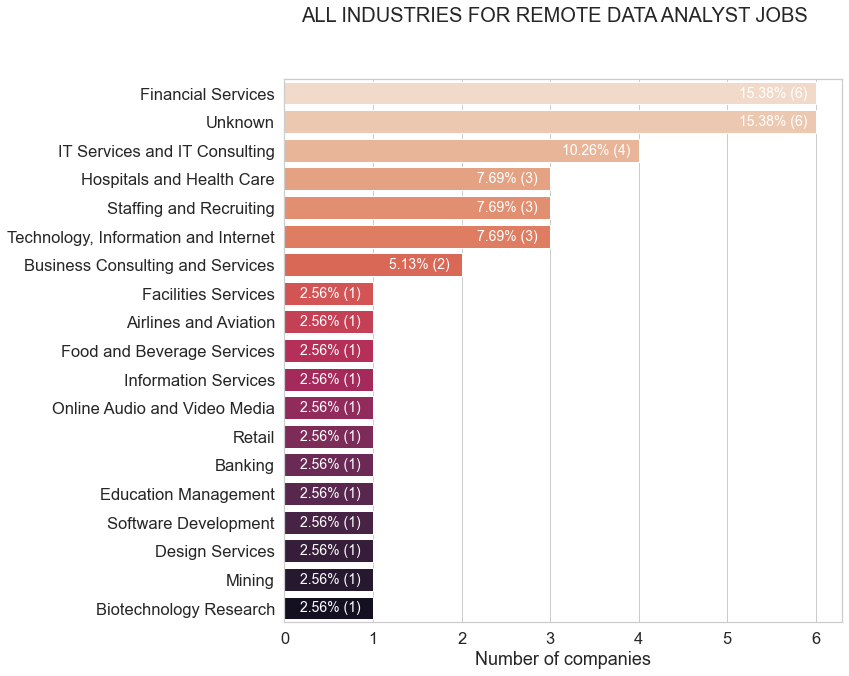

In [486]:
plt.figure(figsize=(10,10))
plot_df = create_df(df_3, 'Industry')
nrows = -1 # to plot all rows: set to 0 or -1
title = 'ALL INDUSTRIES FOR REMOTE DATA ANALYST JOBS'
xlabel = 'Number of companies'
plot_hbar(plot_df, title=title, xlabel= xlabel, nrows=nrows)
plt.show()

In [487]:
# industry_lst = ['Financial Services', 'IT Services and IT Consulting', 'Technology, Information and Internet', 'Software Development', 'Airlines and Aviation', 'Banking', 'Information Services', 'Retail']
# mask_industry = (df_3['Industry'].isin(industry_lst))
mask_entry = (df_3['Level of Expertise']=='Entry level')
df_final = df_3[mask_entry]
print(f'Found {df_final.shape[0]} Data analyst remote jobs for entry level')
df_final

Found 8 Data analyst remote jobs for entry level


,Job URL,Name,Company,Location,Location_City,Location_State,Workplace Type,Time Posted,Applicants Count,Salary,Contract Type,Level of Expertise,Company Size,Industry
12,https://www.linkedin.com/jobs/view/3532901532,Analyst,TNTP,United States,Remote,Remote,Remote,1 week ago,Over 200 applicants,"$72,800/yr - $109,200/yr",Full-time,Entry level,201-500 employees,Education Management
92,https://www.linkedin.com/jobs/view/3529465223,Data Integration Analyst,Huxley,"Boston, MA",Remote,Remote,Remote,2 weeks ago,Over 200 applicants,Unknown,Full-time,Entry level,201-500 employees,Staffing and Recruiting
189,https://www.linkedin.com/jobs/view/3530920144,Remote Data Analyst,Dice,"Cedar Rapids, IA",Remote,Remote,Remote,3 days ago,152 applicants,Unknown,Full-time,Entry level,"1,001-5,000 employees","Technology, Information and Internet"
201,https://www.linkedin.com/jobs/view/3529819530,Remote Data Analyst,Apex Systems,"Cedar Rapids, IA",Remote,Remote,Remote,1 week ago,Over 200 applicants,Unknown,Contract,Entry level,"1,001-5,000 employees",IT Services and IT Consulting
299,https://www.linkedin.com/jobs/view/3545497608,Need SAS Programmer Analyst for remote position.,Dice,United States,Remote,Remote,Remote,2 days ago,25 applicants,Unknown,Contract,Entry level,"1,001-5,000 employees","Technology, Information and Internet"
508,https://www.linkedin.com/jobs/view/3545498124,Data Analyst - $77 CTC - REMOTE,Dice,"Austin, TX",Remote,Remote,Remote,2 days ago,71 applicants,Unknown,Contract,Entry level,"1,001-5,000 employees","Technology, Information and Internet"
554,https://www.linkedin.com/jobs/view/3521913567,Analyst,Nakupuna Companies,United States,Remote,Remote,Remote,2 weeks ago,100 applicants,"$75,000/yr",Full-time,Entry level,"501-1,000 employees",Business Consulting and Services
705,https://www.linkedin.com/jobs/view/3524162828,Procurement Data Analyst (Remote),ISS Facility Services - North America,"San Antonio, TX",Remote,Remote,Remote,2 weeks ago,104 applicants,Unknown,Full-time,Entry level,"10,001+ employees",Facilities Services
